# Task 3 Customer Segmentation Report

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score

# Load datasets
customers = pd.read_csv(r"C:\Users\Abhay Thakur\Downloads\Customers.csv")
products = pd.read_csv(r'C:\Users\Abhay Thakur\Downloads\Products.csv')
transactions = pd.read_csv(r'C:\Users\Abhay Thakur\Downloads\Transactions.csv')


# Extract brand name from ProductName
products['Brand'] = products['ProductName'].str.split().str[0]
products['ProductName'] = products.apply(lambda row: row['ProductName'].replace(row['Brand'] + ' ', ''), axis=1)

# Merge datasets
tf = transactions.merge(products[['ProductID', 'Brand', 'ProductName', 'Category']], on='ProductID', how='left')
tf = tf.merge(customers[['CustomerID', 'Region', 'SignupDate']], on='CustomerID', how='left')

# Convert date columns to datetime
tf['TransactionDate'] = pd.to_datetime(tf['TransactionDate'])
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])

# Display dataset
display(tf.head())


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,Brand,ProductName,Category,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,ComfortLiving,Bluetooth Speaker,Electronics,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,ComfortLiving,Bluetooth Speaker,Electronics,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,ComfortLiving,Bluetooth Speaker,Electronics,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,ComfortLiving,Bluetooth Speaker,Electronics,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,ComfortLiving,Bluetooth Speaker,Electronics,Europe,2022-03-15


In [2]:
# Check if the necessary columns exist
required_columns = ['CustomerID', 'TotalValue', 'TransactionID', 'ProductID', 'Category']
missing_columns = [col for col in required_columns if col not in tf.columns]
if missing_columns:
    raise ValueError(f"The following columns are missing in the dataset: {missing_columns}")

# Aggregate customer-level features
customer_features = tf.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),
    PurchaseFrequency=('TransactionID', 'count'),
    AvgTransactionValue=('TotalValue', 'mean'),
    UniqueProducts=('ProductID', 'nunique'),
    UniqueCategories=('Category', 'nunique')
).reset_index()

# Add DaysSinceSignup and Region
customers['DaysSinceSignup'] = (pd.Timestamp('2025-01-01') - customers['SignupDate']).dt.days
customer_features = customer_features.merge(customers[['CustomerID', 'Region', 'DaysSinceSignup']], on='CustomerID')

# One-hot encode the Region column
customer_features = pd.get_dummies(customer_features, columns=['Region'])

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop('CustomerID', axis=1))


# Clustering 
### We’ll use KMeans clustering and determine the optimal number of clusters using the elbow method.

C:\Users\Abhay Thakur\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abhay Thakur\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Abhay Thakur\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abhay Thakur\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Wind

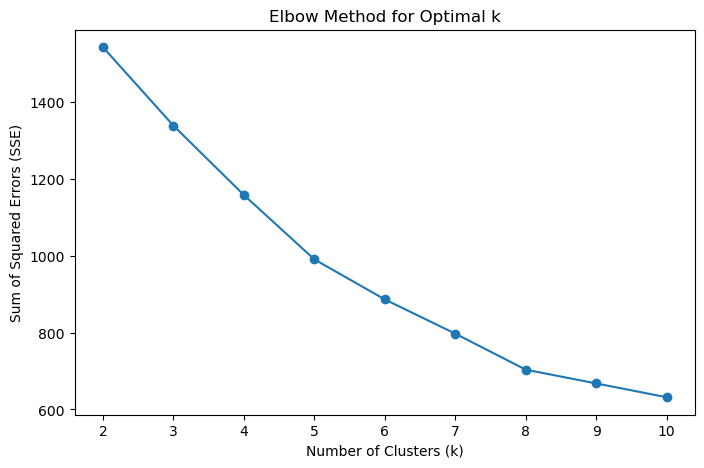

C:\Users\Abhay Thakur\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abhay Thakur\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin Index: 1.30


In [3]:
# Determine the optimal number of clusters using the elbow method
sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()

# Choose the optimal k (e.g., k=5) and fit KMeans
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

# Evaluate the clustering using Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
print(f'Davies-Bouldin Index: {db_index:.2f}')


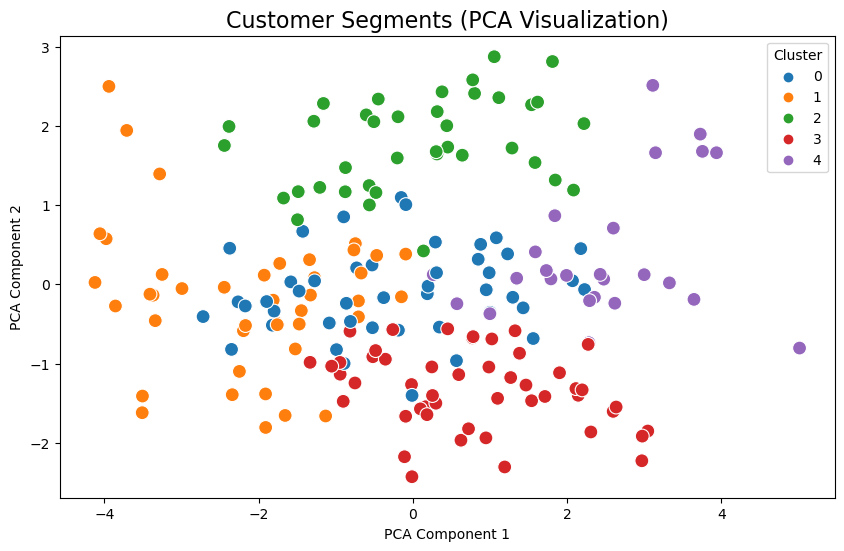

In [4]:
# Reduce dimensions using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_features['Cluster'], palette='tab10', s=100)
plt.title('Customer Segments (PCA Visualization)', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


## Analyzing and Interpreting Clusters

In [5]:
# Summarize clusters
cluster_summary = customer_features.groupby('Cluster').agg(
    AvgSpend=('TotalSpend', 'mean'),
    AvgFrequency=('PurchaseFrequency', 'mean'),
    AvgTransactionValue=('AvgTransactionValue', 'mean'),
    UniqueProducts=('UniqueProducts', 'mean'),
    UniqueCategories=('UniqueCategories', 'mean'),
    AvgDaysSinceSignup=('DaysSinceSignup', 'mean')
).reset_index()

# Display the summary
display(cluster_summary)


,Cluster,AvgSpend,AvgFrequency,AvgTransactionValue,UniqueProducts,UniqueCategories,AvgDaysSinceSignup
0,0,3287.835556,4.688889,711.281836,4.622222,2.933333,551.244444
1,1,1646.442143,2.690476,600.792183,2.642857,1.833333,535.714286
2,2,3124.518947,5.026316,650.422166,5.026316,3.000000,438.052632
3,3,4258.758571,5.734694,747.559949,5.510204,3.081633,594.408163
4,4,5819.260000,8.160000,729.640887,7.760000,3.720000,512.680000
